# Functional Encryption - Classification and information leakage

Next part, we will set a distinguishabilty task. We will need a dataset with a fixed digit for the distinguisher. Therefore we use the same code than in part 1 but set digit to be 6, as it is a fairly representative one of average difficulty.

# 1. Build the dataset

But first, let's build the dataset!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from string import ascii_lowercase
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import torch.utils.data as utils
import pickle

## 1.1 Fonts

In [2]:
families = ['cursive', 'Georgia']

Here what they look like!

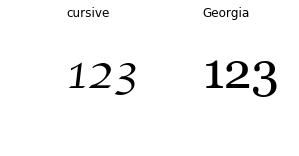

In [3]:
plt.figure(figsize=(12,2))
for i, family in enumerate(families):
    ax = plt.subplot(1, 5, i+1)
    ax.set_title(family)
    ax.text(0.3, 0.4, '123', size=50, family=family)

    # Rm axes, draw and get the rgba shape of the digits
    plt.axis('off')
plt.show()

## 1.2 Noising process
Our dataset is artificial. Hence we need to add some noise to make it more interesting for a classification task.
Currently the noise boils down to:

 - A random but moderate rotation
 - A random but moderation size variation
 - A deformation using a Gaussian filter

When we are done, we recenter the data (as it is done for MNIST).

Let's do it for one character to see how it looks like!

### Utils functions to handle rgb / rgba conversion

In [4]:
def rgba_to_rgb(rgba):
        if rgba[0] > 0:
            return np.ones(3) * (256 - rgba[0])
        return rgba[1:]
    
def convert_to_rgb(data):
    return np.apply_along_axis(rgba_to_rgb, 2, data) 

### Deformation function

In [5]:
def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

### Recentering function

In [6]:
def center(data):
    # Inverse black and white
    wb_data = np.ones(data.shape) * 255 - data
    
    # normalize
    prob_data = wb_data / np.sum(wb_data)
    
    # marginal distributions
    dx = np.sum(prob_data, (1, 2))
    dy = np.sum(prob_data, (0, 2))

    # expected values
    (X, Y, Z) = prob_data.shape
    cx = np.sum(dx * np.arange(X))
    cy = np.sum(dy * np.arange(Y))
    
    # Check bounds
    assert cx > X/4 and cx < 3 * X/4, f"ERROR: {cx} > {X/4} and {cx} < {3 * X/4}"
    assert cy > Y/4 and cy < 3 * Y/4, f"ERROR: {cy} > {Y/4} and {cy} < {3 * Y/4}"
    
    # print('Center', cx, cy)
    
    x_min = int(round(cx - X/4))
    x_max = int(round(cx + X/4))
    y_min = int(round(cy - Y/4))
    y_max = int(round(cy + Y/4))
    
    return data[x_min:x_max, y_min:y_max, :]
    

### One first example!
Ok let's how it looks like!

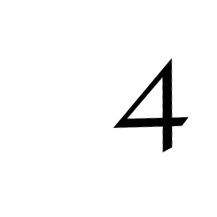

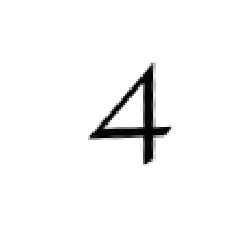

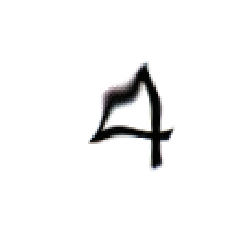

In [9]:
# Sample a rotation angle
rotation = np.random.normal(0, 10) # 10 degrees (out of 180)
# Sample a text size +/- 5% in std
size = 100 + np.random.normal(0, 5) 
# Sample a family
family_idx = np.random.randint(len(families))
family = families[family_idx]
# Sample a char
digit = np.random.randint(10)
letter = str(digit)

# Show rotated letter
fig = plt.figure(figsize=(2,2), dpi=100)
fig.text(0.4, 0.4, letter, size=size, rotation=rotation, family=family)
plt.axis('off')
plt.show()
plt.close(fig)

# Load the letter in smaller size
fig = plt.figure(figsize=(2,2), dpi=100)
fig.text(0.4, 0.4, letter, size=50, rotation=rotation, family=family)

# Rm axes, draw and get the rgba shape of the letter
plt.axis('off')
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))
plt.close(fig)
# Convert to rgb
data = convert_to_rgb(data)

# Re-center the data
data = center(data)

plt.show()
plt.axis('off')
plt.imshow(data)
plt.show()

# Apply an elastic deformation
data = elastic_transform(data, alpha=1100, sigma=7) # 991; 9

plt.axis('off')
plt.imshow(data)
plt.show()

# Free memory space
plt.close(fig)

Notice that the images here are provided with high resolution, they will then be converted to 28x28 pixels and will becomes way harder to analyse.

Feel free to change the rotation std, the text size std, and the `alpha` and `sigma` parameters in the deformation. You'll see that the task can be made incredibly harder!

### Building the dataset
Ok now we are equipped to build a complete dataset!

In [10]:
# We define a variance parameter for rotation and one for text size
std_rotation = 10
std_size = 2.5 # 5% of reference size, here 50

In [14]:
%%time
def build_dataset(dataset_size, digit, verbose=False):
    dataset_data = []
    dataset_target_char = []
    dataset_target_family = []
    for i in range(dataset_size):
        if i % int(dataset_size/100) == 0:
            print(round(i / dataset_size * 100), '%')
        rotation = np.random.normal(0, std_rotation)
        size = 50 + np.random.normal(0, std_size) 
        family_idx = np.random.randint(len(families))
        family = families[family_idx]
        digit = digit #np.random.randint(10)
        letter = str(digit)

        fig = plt.figure(figsize=(2,2), dpi=28)
        fig.text(0.4, 0.4, letter, size=size, rotation=rotation, family=family)

        # Rm axes, draw and get the rgba shape of the letter
        plt.axis('off')
        fig.canvas.draw()
        data = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (4,))

        # Convert to rgb
        data = convert_to_rgb(data)

        # Center the data
        data = center(data)

        if verbose:
            plt.show()
            plt.axis('off')
            plt.imshow(data)
            plt.show()
            
        # Apply an elastic deformation
        data = elastic_transform(data, alpha=991, sigma=9)

        if verbose:
            plt.axis('off')
            plt.imshow(data)
            plt.show()

        # Free memory space
        plt.close(fig)

        # Append data to the datasets
        target_char = np.array([digit])
        target_family = np.array([family_idx])
        dataset_data.append(data[:,:,0])
        dataset_target_char.append(target_char)
        dataset_target_family.append(target_family)
        
    return dataset_data, dataset_target_char, dataset_target_family

digit = 6
def save_dataset(info, data, target_char, target_family):
    with open('dataset/character_dataset_{}_{}_{}.pkl'.format('_'.join(families), digit, info), 'wb') as output:
        dataset = data, target_char, target_family
        pickle.dump(dataset, output, pickle.HIGHEST_PROTOCOL)

# We build 10000 per 10000 for memory purposes
# WARNING: This step takes time, and you may need to restart you notebook for memory purposes.
for i in range(6):
    print(f"Train{i}")
    train_data, train_target_char, train_target_family = build_dataset(10000, digit)
    save_dataset(f"train{i}", train_data, train_target_char, train_target_family)
    
print("Test")
test_data, test_target_char, test_target_family = build_dataset(10000, digit)
save_dataset("test", test_data, test_target_char, test_target_family)

Train0
0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
Train1
0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
Train2

Ok we now have our dataset! Let's use it!

### Appendix
Here is an utility function to draw some samples of the dataset

In [18]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))
import random, math
from learn import collateral
data = collateral.data.load_collateral_data("cursive", "Georgia", "6")
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data

Training set 60000 items
Testing set  10000 items


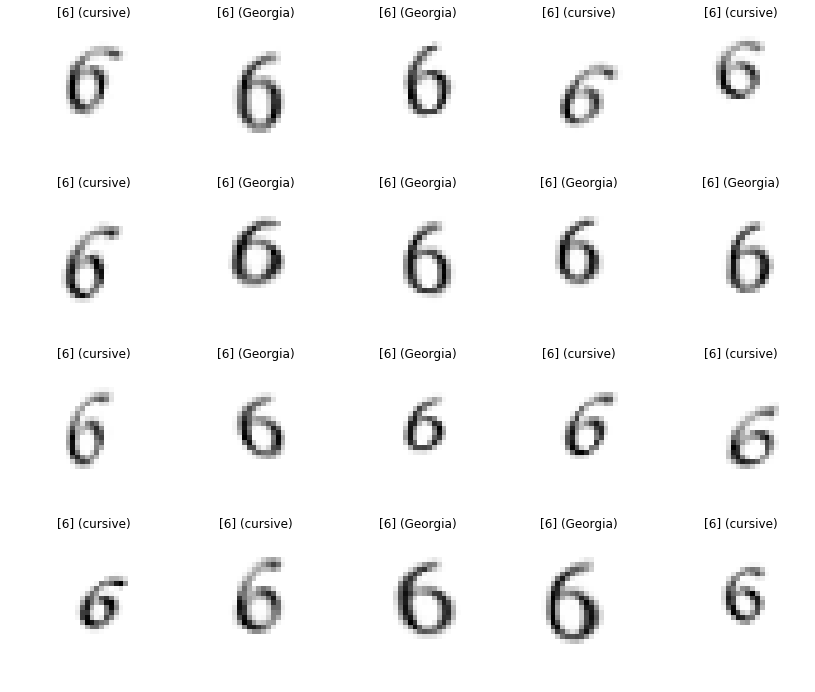

In [19]:
def show_examples(data, target_char, target_family, n_examples=20):
    n_rows = math.ceil(n_examples / 5)
    plt.figure(figsize=(14, 3*n_rows))
    for i in range(n_examples):
        ax = plt.subplot(n_rows, 5, i+1)
        idx = random.randint(0, len(data))
        image = data[idx]
        letter = str([target_char[idx][0]])
        family = families[target_family[idx][0]]
        ax.set_title(f"{letter} ({family})")
        plt.axis('off')
        ax.imshow(image, cmap='gist_gray')
    plt.show()
        
        
show_examples(test_data, test_target_char, test_target_family)

It now much harder to distinguish the fonts, isn't it?!

Ok let's use this dataset to start out work!


### If you like it, star it!

The easiest way to show support is just by starring the Repos! This helps raise awareness on this topics and is a precious feedback for the repo maintainers!

- [Star the Repo](https://github.com/LaRiffle/collateral-learning)